In [8]:
# Cell 1: Setup and Load Data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Fix working directory
project_root = r'c:\projects\retail-analytics-dashboard'
os.chdir(project_root)

print("Working directory:", os.getcwd())
print("=" * 60)

# Check if file exists before loading
file_path = 'data/processed/clean_data.csv'
if not os.path.exists(file_path):
    print(f"❌ ERROR: File not found: {file_path}")
    print(f"\nFiles in data/processed/:")
    if os.path.exists('data/processed'):
        print(os.listdir('data/processed'))
    else:
        print("data/processed/ directory doesn't exist!")
    
    # STOP HERE - don't continue
    raise FileNotFoundError(f"Cannot find {file_path}")

print(f"✓ Found file: {file_path}")

# Load the data
df = pd.read_csv(file_path)
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

print("=" * 60)
print("DATA DIAGNOSIS REPORT")
print("=" * 60)

# Basic info
print(f"\n1. DATASET SIZE")
print(f"   Total rows: {len(df):,}")
print(f"   Total columns: {len(df.columns)}")
print(f"   Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Date range
print(f"\n2. TIME PERIOD")
print(f"   Start date: {df['InvoiceDate'].min()}")
print(f"   End date: {df['InvoiceDate'].max()}")
days = (df['InvoiceDate'].max() - df['InvoiceDate'].min()).days
print(f"   Total days: {days}")
print(f"   Months: {days/30:.1f}")

if days < 180:
    print(f"   ⚠️ WARNING: Only {days/30:.1f} months - Prophet needs 6+")
else:
    print(f"   ✓ Good: {days/30:.1f} months of data")

# Column analysis
print(f"\n3. COLUMNS")
print(df.dtypes)

print(f"\n4. MISSING VALUES")
missing = df.isnull().sum()
missing_pct = (missing / len(df) * 100).round(2)

for col in df.columns:
    if missing[col] > 0:
        print(f"   {col}: {missing[col]:,} ({missing_pct[col]}%)")

Working directory: c:\projects\retail-analytics-dashboard
✓ Found file: data/processed/clean_data.csv
DATA DIAGNOSIS REPORT

1. DATASET SIZE
   Total rows: 397,884
   Total columns: 8
   Memory usage: 97.12 MB

2. TIME PERIOD
   Start date: 2010-12-01 08:26:00
   End date: 2011-12-09 12:50:00
   Total days: 373
   Months: 12.4
   ✓ Good: 12.4 months of data

3. COLUMNS
InvoiceNo               int64
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
dtype: object

4. MISSING VALUES


In [9]:
# Cell 2: Calculate and check TotalSales
if 'TotalSales' not in df.columns:
    df['TotalSales'] = df['Quantity'] * df['UnitPrice']
    print("✓ Created TotalSales column")

# Aggregate to daily
daily_sales = df.groupby(df['InvoiceDate'].dt.date)['TotalSales'].sum()

print("\n5. DAILY SALES STATISTICS")
print(f"   Mean: ${daily_sales.mean():,.2f}")
print(f"   Median: ${daily_sales.median():,.2f}")
print(f"   Std Dev: ${daily_sales.std():,.2f}")
print(f"   Min: ${daily_sales.min():,.2f}")
print(f"   Max: ${daily_sales.max():,.2f}")

# Coefficient of Variation (KEY METRIC)
cv = daily_sales.std() / daily_sales.mean()
print(f"\n   Coefficient of Variation: {cv:.2f}")
if cv < 0.5:
    print("   ✓ Low variance - Good for forecasting")
elif cv < 1.0:
    print("   ⚠️ Moderate variance - Forecasting will be challenging")
elif cv < 2.0:
    print("   ⚠️ High variance - Forecasting will be difficult")
else:
    print("   ❌ Very high variance - Simple models may not work")

✓ Created TotalSales column

5. DAILY SALES STATISTICS
   Mean: $29,217.73
   Median: $25,489.66
   Std Dev: $17,855.00
   Min: $3,457.11
   Max: $184,349.28

   Coefficient of Variation: 0.61
   ⚠️ Moderate variance - Forecasting will be challenging


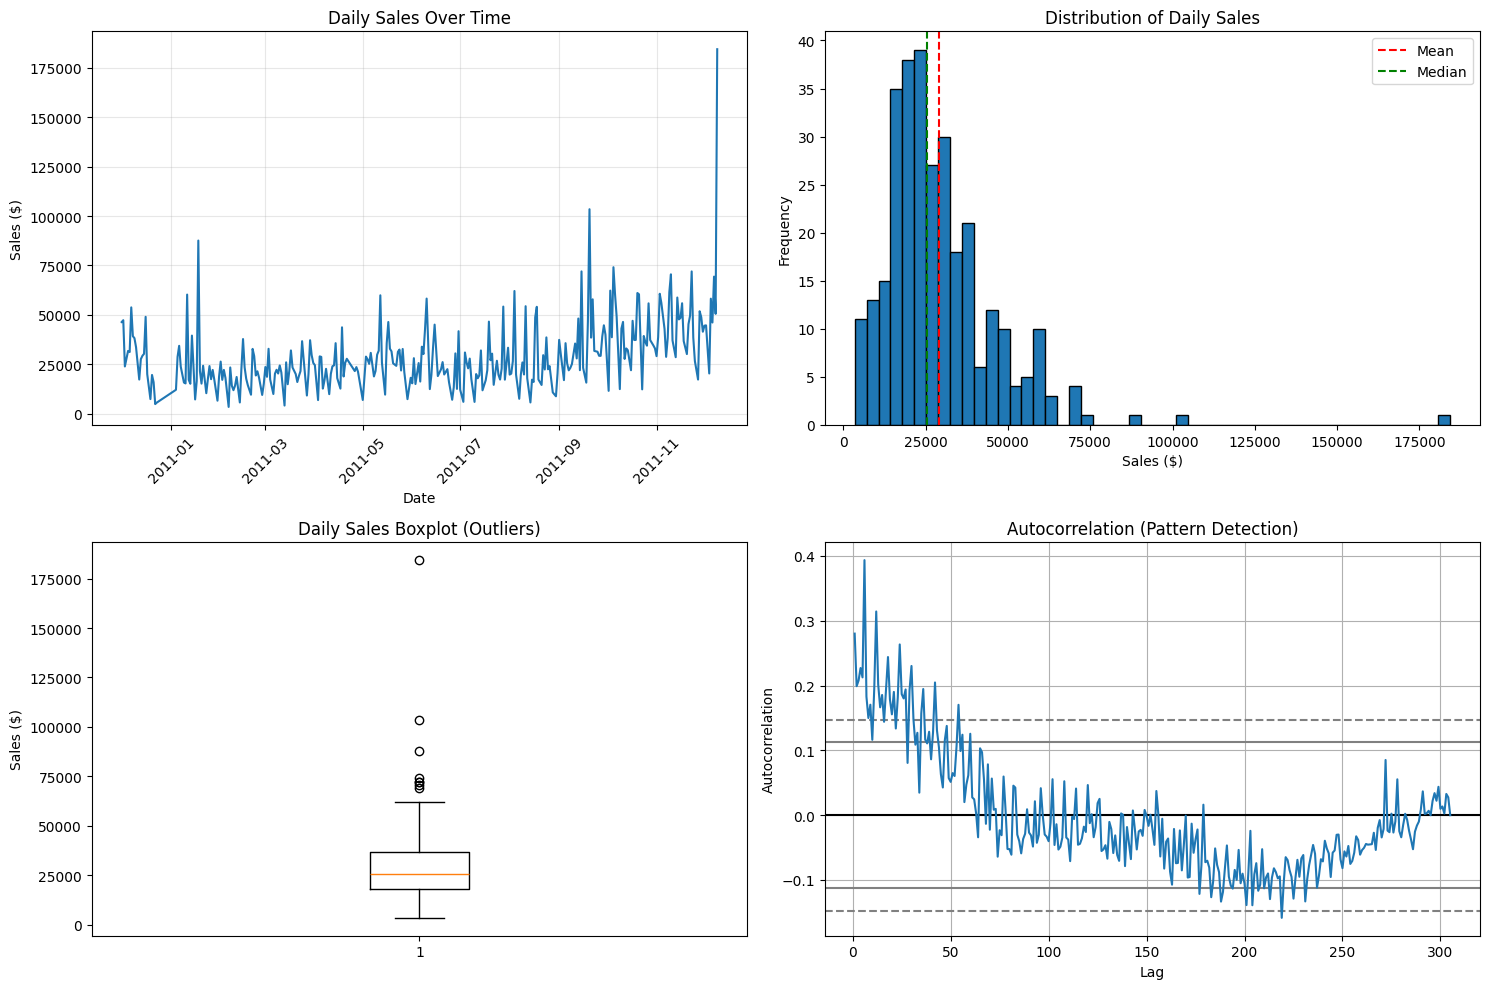


✓ Plots saved to docs/data_diagnosis.png


In [10]:
# Cell 3: Visualize the data
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Time series
axes[0, 0].plot(daily_sales.index, daily_sales.values)
axes[0, 0].set_title('Daily Sales Over Time')
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Sales ($)')
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Distribution
axes[0, 1].hist(daily_sales, bins=50, edgecolor='black')
axes[0, 1].set_title('Distribution of Daily Sales')
axes[0, 1].set_xlabel('Sales ($)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].axvline(daily_sales.mean(), color='red', linestyle='--', label='Mean')
axes[0, 1].axvline(daily_sales.median(), color='green', linestyle='--', label='Median')
axes[0, 1].legend()

# Plot 3: Boxplot
axes[1, 0].boxplot(daily_sales)
axes[1, 0].set_title('Daily Sales Boxplot (Outliers)')
axes[1, 0].set_ylabel('Sales ($)')

# Plot 4: Autocorrelation (are sales today related to sales yesterday?)
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(daily_sales, ax=axes[1, 1])
axes[1, 1].set_title('Autocorrelation (Pattern Detection)')

plt.tight_layout()
plt.savefig('docs/data_diagnosis.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Plots saved to docs/data_diagnosis.png")

In [11]:
# Cell 4: Detect specific issues
print("\n6. SPECIFIC ISSUES TO FIX")

# Issue 1: Zero sales days
zero_days = (daily_sales == 0).sum()
if zero_days > 0:
    print(f"   ❌ {zero_days} days with $0 sales")
    print(f"      These could be: weekends, holidays, or data gaps")
    print(f"      Recommendation: Fill with interpolation or mark as special days")

# Issue 2: Outliers
Q1 = daily_sales.quantile(0.25)
Q3 = daily_sales.quantile(0.75)
IQR = Q3 - Q1
outliers = daily_sales[(daily_sales < Q1 - 3*IQR) | (daily_sales > Q3 + 3*IQR)]
print(f"\n   {'❌' if len(outliers) > 10 else '⚠️'} {len(outliers)} outlier days detected")
if len(outliers) > 0:
    print(f"      Dates: {list(outliers.index[:5])}")
    print(f"      Values: {[f'${x:,.0f}' for x in outliers.values[:5]]}")
    print(f"      Recommendation: Investigate these days, might be sales events")

# Issue 3: Gaps in data
date_range = pd.date_range(daily_sales.index.min(), daily_sales.index.max())
missing_dates = date_range.difference(pd.DatetimeIndex(daily_sales.index))
if len(missing_dates) > 0:
    print(f"\n   ⚠️ {len(missing_dates)} missing dates in sequence")
    print(f"      First few: {list(missing_dates[:5])}")
    print(f"      Recommendation: Forward-fill or mark as no-sales days")

# Issue 4: Trend check
from scipy import stats
x = np.arange(len(daily_sales))
slope, intercept, r_value, p_value, std_err = stats.linregress(x, daily_sales.values)
print(f"\n   Trend Analysis:")
print(f"      Slope: ${slope:.2f}/day")
if slope > 0:
    print(f"      ✓ Growing trend (good for multiplicative seasonality)")
elif slope < -100:
    print(f"      ⚠️ Declining trend (business issue?)")
else:
    print(f"      ⚠️ Flat trend (additive seasonality better)")


6. SPECIFIC ISSUES TO FIX

   ⚠️ 2 outlier days detected
      Dates: [datetime.date(2011, 9, 20), datetime.date(2011, 12, 9)]
      Values: ['$103,436', '$184,349']
      Recommendation: Investigate these days, might be sales events

   ⚠️ 69 missing dates in sequence
      First few: [Timestamp('2010-12-04 00:00:00'), Timestamp('2010-12-11 00:00:00'), Timestamp('2010-12-18 00:00:00'), Timestamp('2010-12-24 00:00:00'), Timestamp('2010-12-25 00:00:00')]
      Recommendation: Forward-fill or mark as no-sales days

   Trend Analysis:
      Slope: $81.68/day
      ✓ Growing trend (good for multiplicative seasonality)


In [12]:
# Cell 5: Final recommendation
print("\n" + "=" * 60)
print("RECOMMENDATIONS FOR MODEL IMPROVEMENT")
print("=" * 60)

days_of_data = (df['InvoiceDate'].max() - df['InvoiceDate'].min()).days

print("\n1. DATA PREPROCESSING NEEDED:")
recommendations = []

if days_of_data < 180:
    recommendations.append("   ❌ CRITICAL: Only {:.1f} months of data. Prophet needs 6+".format(days_of_data/30))
    recommendations.append("      → Solution: Use simpler models (Moving Average, Exponential Smoothing)")
    
if cv > 1.5:
    recommendations.append("   ⚠️ High variance detected")
    recommendations.append("      → Solution: Log-transform data or use robust models")

if zero_days > 0:
    recommendations.append("   ⚠️ Zero-sales days found")
    recommendations.append("      → Solution: Fill gaps or add 'is_weekend' feature")

if len(outliers) > 10:
    recommendations.append("   ⚠️ Many outliers detected")
    recommendations.append("      → Solution: Winsorize (cap extremes) or add holiday features")

for rec in recommendations:
    print(rec)

print("\n2. MODEL STRATEGY:")
if days_of_data < 180:
    print("   → START WITH: Moving Average or Exponential Smoothing")
    print("   → THEN TRY: ARIMA (needs less data than Prophet)")
    print("   → SKIP FOR NOW: Prophet (needs more data)")
else:
    print("   → START WITH: Prophet with additive seasonality")
    print("   → THEN TRY: ARIMA, Exponential Smoothing")
    print("   → ADVANCED: XGBoost with feature engineering")

print("\n3. IMMEDIATE NEXT STEPS:")
print("   1. Fix data quality issues (run data cleaning script)")
print("   2. Create multiple model versions (baseline → simple → complex)")
print("   3. Compare all models fairly (same train/test split)")
print("   4. Pick best performer for dashboard")


RECOMMENDATIONS FOR MODEL IMPROVEMENT

1. DATA PREPROCESSING NEEDED:

2. MODEL STRATEGY:
   → START WITH: Prophet with additive seasonality
   → THEN TRY: ARIMA, Exponential Smoothing
   → ADVANCED: XGBoost with feature engineering

3. IMMEDIATE NEXT STEPS:
   1. Fix data quality issues (run data cleaning script)
   2. Create multiple model versions (baseline → simple → complex)
   3. Compare all models fairly (same train/test split)
   4. Pick best performer for dashboard
